# Importing and Tidying Data

bikeshare_nyc_raw.csv:
* dock_id: official dock id provided by Citi Bike
* dock_name: official dock name provided by Citi Bike
* date: year-month-day format
* hour: hour of day (am/pm is determined by ‘pm’ variable)
* minute: minute of hour
* pm: 0–am 1–pm
* avail_bikes: number of available bikes
* avail_docks: number of available (empty) docks
* tot_docks: number of functioning (online) docks
* _lat: degrees latitude of station
* _long: degrees longitude of station

New properties
* statusValue: "Not In Service",
* statusKey: 3,
* stAddress1: "Pitt St & Stanton St",
* stAddress2: "",
* city: "",
* postalCode: "",
* location: "",
* altitude: "",
* testStation: false,
* lastCommunicationTime: "2018-03-16 04:17:02 AM",
* landMark: ""

In [1]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
#hacky method of getting folder names and breaking folders containing CSVs into four groups
pathName2 = os.getcwd() + '/AvailabilityData2'
folderNames2 = os.listdir(pathName2)
folderBatch3 = folderNames2[8:-2]

#function that takes folder groups and takes their respective CSVs for combining, cleaning and setting datatypes
def importAndCleanData(pathName, folderBatch):
    # loop through each folder batches to append csv data to a dataframe (even the dirty data, coerce dtype errors later)
    dock_availability_df = pd.DataFrame()
    for folder in folderBatch:
        dock_availability_df = dock_availability_df.append(pd.read_csv(pathName+'/'+ folder +'/bikeshare_nyc_raw.csv',sep='\t',error_bad_lines = False
#                               ,warn_bad_lines=False
                             ))
    

    #create list of columns created by ignoring bad line errors and name it dirty_columns
    clean_columns = ['dock_id','dock_name','date','hour','minute','pm','avail_bikes','avail_docks','tot_docks','_lat','_long', 'in_service', 'status_key']
    dirty_columns = [c for c in dock_availability_df.columns if c not in clean_columns]

    #delete the rows that have values for the dirty columns and delete the dirty columns
    for column in dirty_columns:
#         dock_availability_df = dock_availability_df.drop(dock_availability_df[column].notnull())
        dock_availability_df = dock_availability_df.drop(column, axis=1)

    #convert columns to correct dtypes -decrease memory usage- and coerce errors
    numeric_columns = ['dock_id','hour','minute','avail_bikes','avail_docks','tot_docks','_lat','_long']
    category_columns = ['pm','in_service', 'status_key']
    dock_availability_df['date'] = pd.to_datetime(dock_availability_df['date'], format = '%y-%m-%d')

    for column in numeric_columns:
        dock_availability_df[column] = pd.to_numeric(dock_availability_df[column], errors = 'coerce')
        
    for column in category_columns:
        dock_availability_df[column] = dock_availability_df[column].astype('category')

    #drop rows with NaNs
    dock_availability_df = dock_availability_df.dropna()

    return dock_availability_df

In [3]:
station_availability_df = importAndCleanData(pathName2, folderBatch3)

In [4]:
#transform hour + pm into 24hr
station_availability_df.loc[station_availability_df.pm == 1, 'hour'] = station_availability_df.loc[station_availability_df.pm == 1, 'hour'] + 12
station_availability_df.loc[(station_availability_df['hour'] == 12),'hour'] = 0
station_availability_df.loc[(station_availability_df['hour'] == 24),'hour'] = 12
station_availability_df = station_availability_df.drop('pm', axis=1)
station_availability_df.head()

,dock_id,dock_name,date,hour,minute,avail_bikes,avail_docks,tot_docks,_lat,_long,in_service,status_key
0,72,W 52 St & 11 Ave,2017-02-01,14,22,4,35,39,40.767272,-73.993929,1,1
1,72,W 52 St & 11 Ave,2017-02-01,15,35,1,38,39,40.767272,-73.993929,1,1
2,72,W 52 St & 11 Ave,2017-02-01,16,49,0,39,39,40.767272,-73.993929,1,1
3,72,W 52 St & 11 Ave,2017-02-01,18,2,0,39,39,40.767272,-73.993929,1,1
4,72,W 52 St & 11 Ave,2017-02-01,20,16,7,32,39,40.767272,-73.993929,1,1


In [5]:
station_availability_df['dow'] = station_availability_df.date.apply(lambda x : x.weekday())
station_availability_df['month'] = station_availability_df.date.apply(lambda x : x.month)
station_availability_df = station_availability_df.rename(index=str, columns={"_lat": "lat", "_long": "long"})

# Exploring and Cleaning Data

In [6]:
# def check_null_or_valid(row_data):
#     """Function that takes a row of data,
#     drops all missing values,
#     and checks if all remaining values are greater than or equal to 0
#     """
#     no_na = row_data.dropna()[1:-1]
#     numeric = pd.to_numeric(no_na)
#     ge0 = numeric >= 0
#     return ge0

# # Check whether the first column is 'Life expectancy'
# assert g1800s.columns[0] == 'Life expectancy'

# # Check whether the values in the row are valid
# assert g1800s.iloc[:, 1:].apply(check_null_or_valid, axis=1).all().all()

# # Check that there is only one instance of each country
# assert g1800s['Life expectancy'].value_counts()[0] == 1

In [7]:
print(station_availability_df.info())
#drop rows with null values in dirty columns: 27662565 records
#drop rows with values in dirty columns: 26290342

<class 'pandas.core.frame.DataFrame'>
Index: 4943453 entries, 0 to 505303
Data columns (total 14 columns):
dock_id        int64
dock_name      object
date           datetime64[ns]
hour           int64
minute         int64
avail_bikes    int64
avail_docks    int64
tot_docks      int64
lat            float64
long           float64
in_service     category
status_key     category
dow            int64
month          int64
dtypes: category(2), datetime64[ns](1), float64(2), int64(8), object(1)
memory usage: 499.7+ MB
None


In [8]:
print(station_availability_df.describe())

            dock_id          hour        minute   avail_bikes   avail_docks  \
count  4.943453e+06  4.943453e+06  4.943453e+06  4.943453e+06  4.943453e+06   
mean   1.991637e+03  1.149240e+01  2.940147e+01  1.142064e+01  1.835629e+01   
std    1.421996e+03  7.062601e+00  1.731523e+01  1.067503e+01  1.298200e+01   
min    7.200000e+01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    4.050000e+02  5.000000e+00  1.400000e+01  2.000000e+00  8.000000e+00   
50%    3.074000e+03  1.200000e+01  2.900000e+01  9.000000e+00  1.700000e+01   
75%    3.284000e+03  1.800000e+01  4.500000e+01  1.800000e+01  2.700000e+01   
max    3.497000e+03  2.300000e+01  5.900000e+01  6.700000e+01  6.700000e+01   

          tot_docks           lat          long           dow         month  
count  4.943453e+06  4.943453e+06  4.943453e+06  4.943453e+06  4.943453e+06  
mean   3.102225e+01  4.072740e+01 -7.398378e+01  3.036674e+00  7.713520e+00  
std    1.088965e+01  3.488048e-02  2.878978e-02  1.966

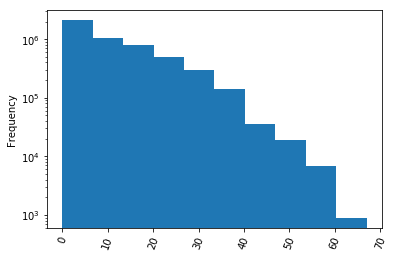

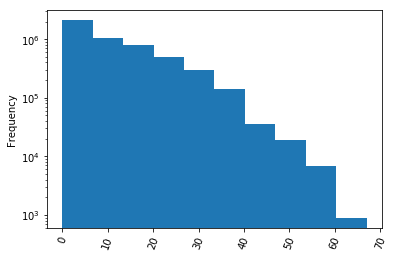

In [9]:
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
%matplotlib inline

# get rid of avail_bikes outliers
station_availability_df['avail_bikes'].plot(kind='hist', rot=70, logy=True)
plt.show()
station_availability_df = station_availability_df[station_availability_df.avail_bikes <= 100]
station_availability_df['avail_bikes'].plot(kind='hist', rot=70, logy=True)
plt.show()

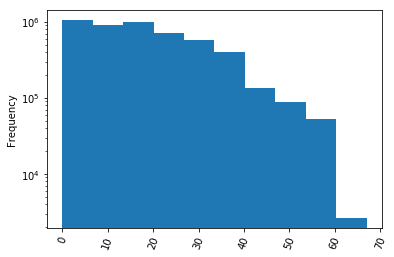

In [10]:
# no avail_docks outliers to get rid of
station_availability_df['avail_docks'].plot(kind='hist', rot=70, logy=True)

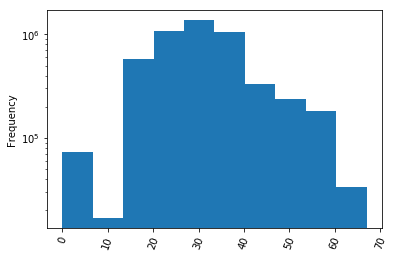

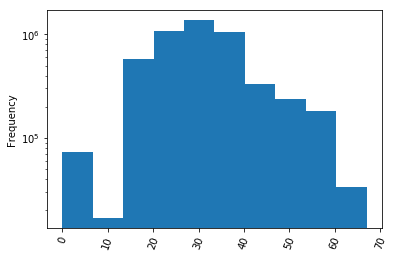

In [11]:
# get rid of tot_docks outliers
station_availability_df['tot_docks'].plot(kind='hist', rot=70, logy=True)
plt.show()
station_availability_df = station_availability_df[station_availability_df.tot_docks != 2727]
station_availability_df['tot_docks'].plot(kind='hist', rot=70, logy=True)
plt.show()

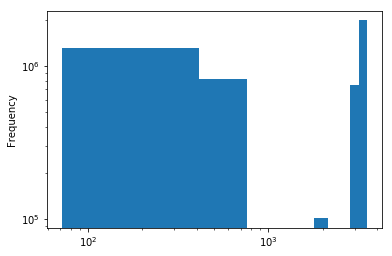

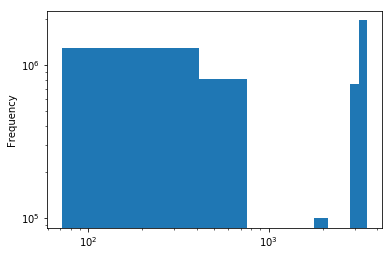

In [12]:
#get rid of docks without enough data points: more or equal to 1440, as this is how many rows a dock generates a month
station_availability_df['dock_id'].plot(kind='hist', logx = True, logy=True)
plt.show()
station_availability_df = station_availability_df.groupby('dock_id').filter(lambda x: len(x) >= 1440)
station_availability_df['dock_id'].plot(kind='hist', logx = True, logy=True)
plt.show()

In [13]:
#see data distribution of active/inactive stations
station_availability_df.loc[station_availability_df['status_key']==1,'status_value'] = "In Service"
station_availability_df.loc[station_availability_df['status_key']==3,'status_value'] = "Not In Service"
station_availability_df.status_value.value_counts()

In Service        4725719
Not In Service     206571
Name: status_value, dtype: int64

In [14]:
#function for seeing average number of bikes at a dock over the hours of the day, averaged amongst every day
def plotAverageAvailBikes(dockId):
    plt.rcParams['figure.figsize'] = [30.0, 10.0]
    graph_df = station_availability_df[station_availability_df['dock_id']==dockId].groupby(['hour']).agg({'avail_bikes': [np.mean]})
    graph_df = graph_df.reset_index()
    graph_df.columns = graph_df.columns.droplevel(1)
    plt.plot(graph_df['hour'], graph_df['avail_bikes'])
    plt.xlabel('hour')
    plt.xticks(range(0,25))
    plt.ylabel('avail_bikes')
    plt.show()

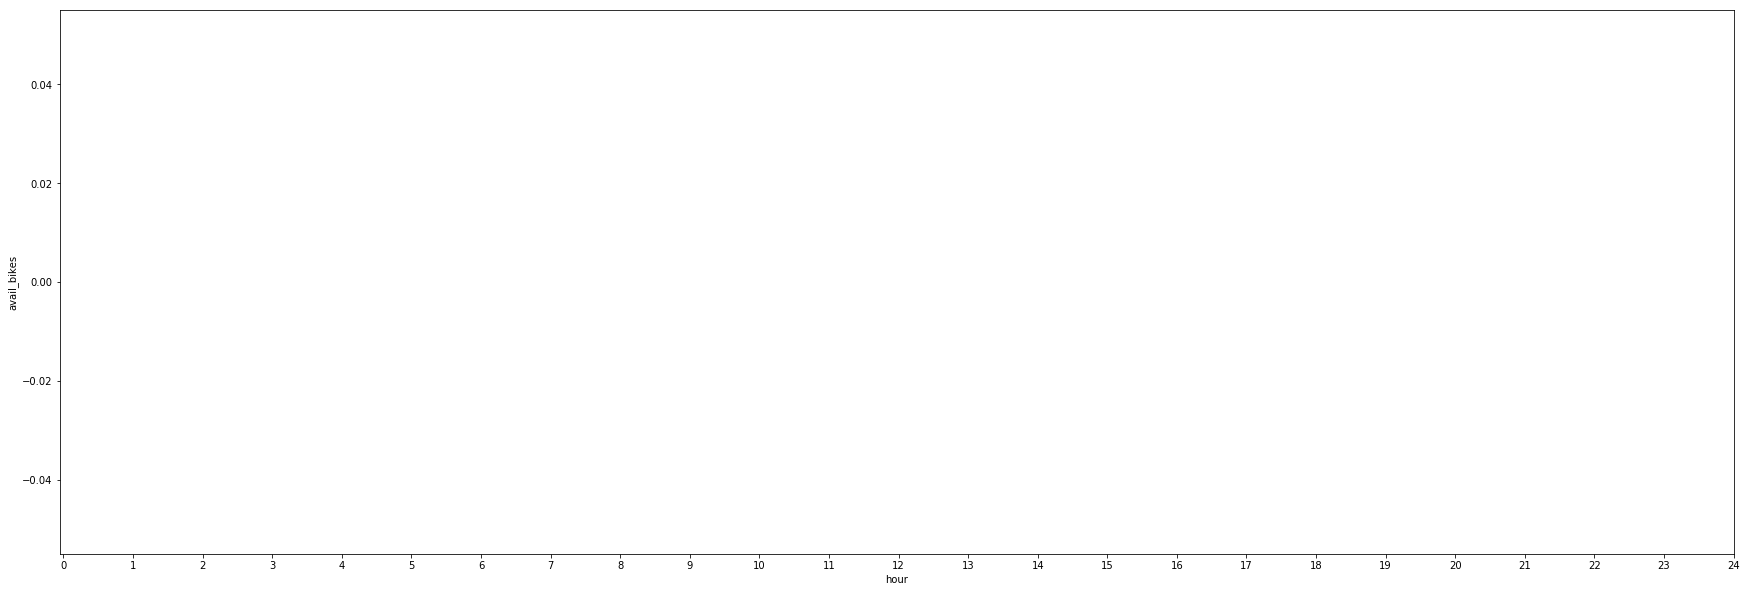

In [15]:
# most rebalancing
plotAverageAvailBikes(521)

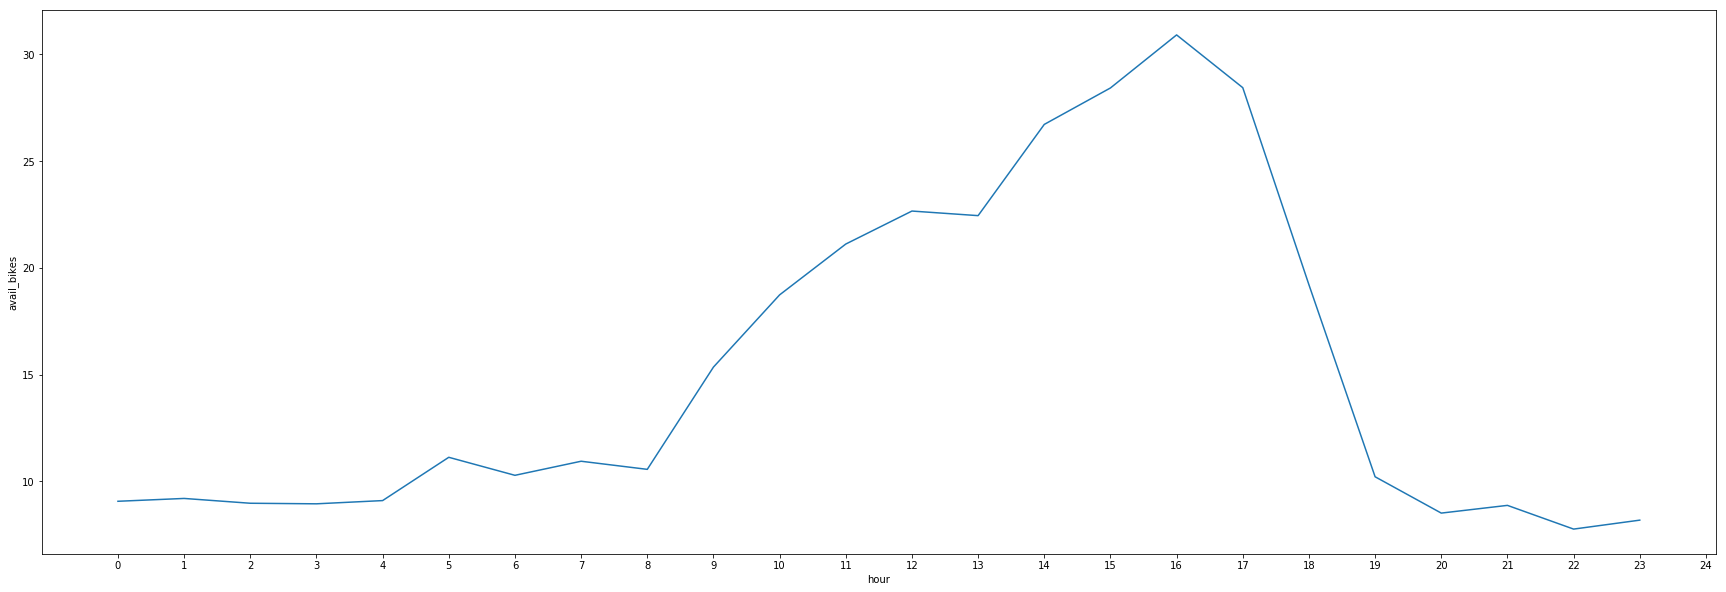

In [ ]:
# most bikes taken
plotAverageAvailBikes(519)

In [ ]:
station_availability_df.to_csv('station_availability_df')